In [1]:
from keras_applications.resnet_1d import ResNet18
from segmentation_models.models.unet_1d import Unet1D

import sys
sys.path.append('../src')

from data_utils import preprocess_dataset, data_augmentation, feature_scaler

%load_ext autoreload
%autoreload 2

Segmentation Models: using `tf.keras` framework.


# Load and pre-process the data

In [2]:
# obtain preprocessed data
db_folder="../data/physionet.org/files/ucddb/1.0.0"
raw_data, _, constants = preprocess_dataset(db_folder)
sample_rate, n_signals = constants

# unpack the data
X, y = raw_data

/Users/polinasimkina/apneal_project/notebooks/../src/data_utils.py:99: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt = pd.to_datetime(respevents["Time"]) - pd.to_datetime(subject_details.loc[0, "PSG Start Time"])
104it [00:28,  3.63it/s]


In [3]:
# pre-process data samples into smaller time bunches 10s
X, y = data_augmentation(X, y, dt=10, sample_rate=sample_rate)

100%|██████████████████████████████████████████| 25/25 [00:00<00:00, 993.80it/s]


In [4]:
print(X.shape, y.shape)

# cut the sample in 2 as not enough resources
X, y = X[:len(X)//2], y[:len(y)//2]

print(X.shape, y.shape)

(53075, 1280, 14) (53075, 1280, 1)
(26537, 1280, 14) (26537, 1280, 1)


In [5]:
# separate the dataset into train/validation/test. 
n_samples = X.shape[0]
Xtrain, Xvalid, Xtest, ytrain, yvalid, ytest = X[:int(0.7*n_samples)], X[int(0.7*n_samples):int(0.85*n_samples)], X[int(0.85*n_samples):], y[:int(0.7*n_samples)], y[int(0.7*n_samples):int(0.85*n_samples)], y[int(0.85*n_samples):]

In [6]:
Xtrain.shape, ytrain.shape, Xvalid.shape, yvalid.shape, Xtest.shape, ytest.shape

((18575, 1280, 14),
 (18575, 1280, 1),
 (3981, 1280, 14),
 (3981, 1280, 1),
 (3981, 1280, 14),
 (3981, 1280, 1))

In [7]:
# scaling the input features using StandardScaler
for i in range(Xtrain.shape[2]):
    Xtrain[:,:,i], Xvalid[:,:,i], Xtest[:,:,i] = feature_scaler(Xtrain[:,:,i], Xvalid[:,:,i], Xtest[:,:,i])

In [8]:
# delete the 3rd input feature as it is 0 
import numpy as np

print(Xtrain.shape)

Xtrain = np.delete(Xtrain, 3, axis=2)
Xvalid = np.delete(Xvalid, 3, axis=2)
Xtest = np.delete(Xtest, 3, axis=2)

print(Xtrain.shape)

(18575, 1280, 14)
(18575, 1280, 13)


# Load model

In [12]:
BACKBONE = 'resnet18_1d'

model = Unet1D(BACKBONE, input_shape= (None, 13), encoder_weights=None, classes=1, activation='sigmoid')
model.summary()

model.compile('Adam', 'binary_crossentropy', ['binary_accuracy'])

2023-08-23 00:33:49.657047: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-08-23 00:33:49.657076: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-08-23 00:33:49.657088: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-08-23 00:33:49.657306: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-23 00:33:49.657730: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 13)]           0         []                            
                                                                                                  
 conv1_pad (ZeroPadding1D)   (None, None, 13)             0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv1D)         (None, None, 64)             5888      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, 64)             256       ['conv1_conv[0][0]']          
 on)                                                                                          

# First baseline training

In [13]:
history = model.fit(Xtrain, ytrain, 
                    epochs=20, 
                    validation_data=(Xvalid, yvalid),
                    batch_size=64)

Epoch 1/20


2023-08-23 00:33:56.184464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


291/291 [==============================] - ETA: 0s - loss: 0.3657 - binary_accuracy: 0.8860

2023-08-23 00:37:07.335788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


291/291 [==============================] - 200s 638ms/step - loss: 0.3657 - binary_accuracy: 0.8860 - val_loss: 0.3649 - val_binary_accuracy: 0.8802
Epoch 2/20
291/291 [==============================] - 173s 594ms/step - loss: 0.3407 - binary_accuracy: 0.8917 - val_loss: 0.3652 - val_binary_accuracy: 0.8802
Epoch 3/20
291/291 [==============================] - 135s 464ms/step - loss: 0.3400 - binary_accuracy: 0.8916 - val_loss: 0.3611 - val_binary_accuracy: 0.8802
Epoch 4/20
291/291 [==============================] - 471s 2s/step - loss: 0.3381 - binary_accuracy: 0.8917 - val_loss: 0.3672 - val_binary_accuracy: 0.8802
Epoch 5/20
291/291 [==============================] - 192s 661ms/step - loss: 0.3385 - binary_accuracy: 0.8916 - val_loss: 0.3618 - val_binary_accuracy: 0.8802
Epoch 6/20
291/291 [==============================] - 189s 651ms/step - loss: 0.3373 - binary_accuracy: 0.8915 - val_loss: 0.3670 - val_binary_accuracy: 0.8802
Epoch 7/20
291/291 [==============================] - 

In [14]:
# Save the weights
model.save_weights('../models/baseline_1')

# Evaluation on validation dataset

In [2]:
# predict the results on the validation dataset
ypr = model.predict(Xvalid)

NameError: name 'model' is not defined

In [3]:
from visualisation import draw_metrics
draw_metrics(ypr, yvalid)

NameError: name 'draw_metrics' is not defined

In [18]:
# check the amount of classes in the train and validation dataset
(ytrain == True).sum()/len(ytrain.flatten()), (ytrain == False).sum()/len(ytrain.flatten())

(0.10832301480484523, 0.8916769851951548)

In [19]:
(yvalid == True).sum()/len(yvalid.flatten()), (yvalid == False).sum()/len(yvalid.flatten())

(0.11984426023612157, 0.8801557397638784)

# Improving for imbalanced classes

In [4]:
import tensorflow as tf

BACKBONE = 'resnet18_1d'
model = Unet1D(BACKBONE, input_shape= (None, 13), classes=1, activation='sigmoid')
model.summary()

# using focal loss
model.compile('Adam', tf.keras.losses.BinaryFocalCrossentropy(), ['binary_accuracy'])

NameError: name 'Unet1D' is not defined

In [5]:
# adding sample weights

sample_weight = np.ones(shape=ytrain.shape)
sample_weight[ytrain[:,:,0]] = 2

NameError: name 'np' is not defined

In [22]:
history = model.fit(Xtrain, ytrain.astype(int), 
                    epochs=20, 
                    validation_data=(Xvalid, yvalid.astype(int)),
                    batch_size=64, sample_weight=sample_weight)

Epoch 1/20


2023-08-23 01:58:35.017369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


291/291 [==============================] - ETA: 0s - loss: 0.1501 - binary_accuracy: 0.8710

2023-08-23 02:01:43.710097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


291/291 [==============================] - 201s 590ms/step - loss: 0.1501 - binary_accuracy: 0.8710 - val_loss: 0.1072 - val_binary_accuracy: 0.8790
Epoch 2/20
291/291 [==============================] - 204s 700ms/step - loss: 0.1414 - binary_accuracy: 0.8902 - val_loss: 0.1025 - val_binary_accuracy: 0.8806
Epoch 3/20
291/291 [==============================] - 203s 698ms/step - loss: 0.1405 - binary_accuracy: 0.8907 - val_loss: 0.1013 - val_binary_accuracy: 0.8792
Epoch 4/20
291/291 [==============================] - 204s 702ms/step - loss: 0.1399 - binary_accuracy: 0.8906 - val_loss: 0.1005 - val_binary_accuracy: 0.8809
Epoch 5/20
291/291 [==============================] - 200s 686ms/step - loss: 0.1396 - binary_accuracy: 0.8904 - val_loss: 0.1023 - val_binary_accuracy: 0.8782
Epoch 6/20
291/291 [==============================] - 201s 690ms/step - loss: 0.1393 - binary_accuracy: 0.8911 - val_loss: 0.1007 - val_binary_accuracy: 0.8799
Epoch 7/20
291/291 [==============================]

2023-08-23 09:05:27.056415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 13s 60ms/step


/Users/polinasimkina/apneal_project/notebooks/../src/visualisation.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax[0].plot([0, 1], [0, 1], 'k--', color='red')


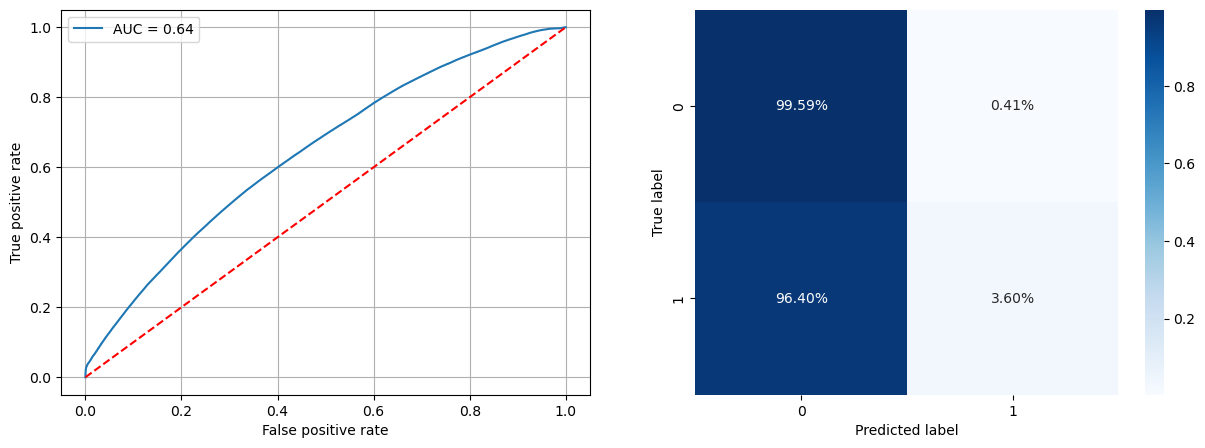

In [23]:
ypr = model.predict(Xvalid)
draw_metrics(ypr, yvalid)

In [24]:
# Save the weights
model.save_weights('../models/opt_loss')

# Test the model on the test dataset

125/125 [==============================] - 6s 45ms/step


/Users/polinasimkina/apneal_project/notebooks/../src/visualisation.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax[0].plot([0, 1], [0, 1], 'k--', color='red')


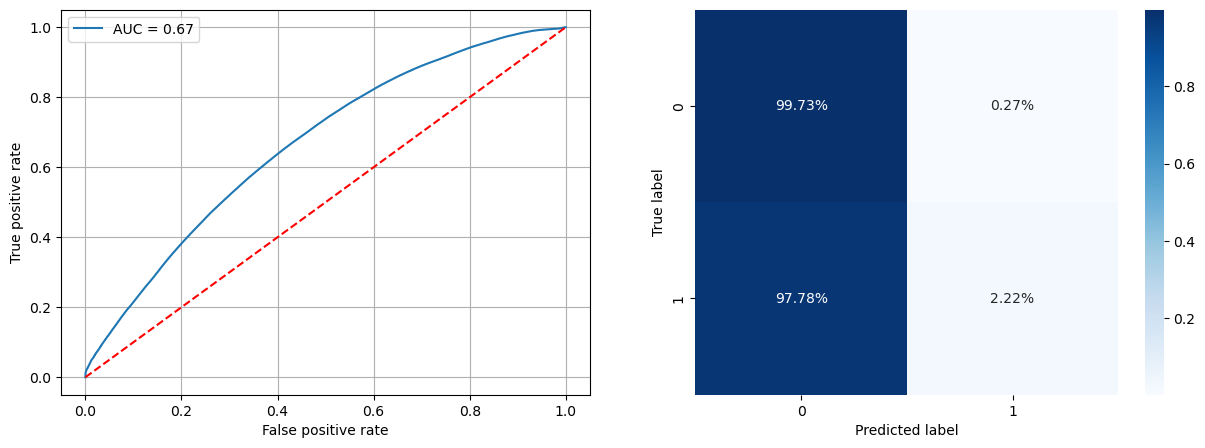

In [25]:
ypr_test = model.predict(Xtest)
draw_metrics(ypr_test, ytest)